In [8]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import re
import spacy
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, TFBertModel

In [9]:
# Load data from Google Sheets link
data_url = "https://docs.google.com/spreadsheets/d/117X6i53dKiO7w6kuA1g1TpdTlv1173h_dPlJt5cNNMU/export?format=csv"
dataset_original = pd.read_csv(data_url)

In [10]:
# Inspecting & Cleaning the dataset
dataset_cleaned_temp = dataset_original.copy()

# Checking missing data
dataset_cleaned_temp.isnull().sum()

# Checking duplicates
dataset_cleaned_temp.duplicated().sum()

# Remove unnecessary words & Replace abbreviations
spacy_nlp = spacy.load('en_core_web_sm')
stemmer = PorterStemmer()
abbreviations_to_replace = {
    'GPHR': 'Global Professional in Human Resources',
    'CSR': 'Corporate Social Responsibility',
    'MES': 'Manufacturing Execution Systems',
    'SPHR': 'Senior Professional in Human Resources',
    'SVP': 'Senior Vice President',
    'GIS': 'Geographic Information System',
    'RRP': 'Reduced Risk Products',
    'CHRO': 'Chief Human Resources Officer',
    'HRIS': 'Human resources information system',
    'HR': 'Human resources',
}

def replace_abbreviations(sentence):
    replaced_sentence = sentence
    for abbreviation, replacement in abbreviations_to_replace.items():
        pattern = r'\b{}\b'.format(re.escape(abbreviation))
        replaced_sentence = re.sub(pattern, replacement, replaced_sentence, flags=re.IGNORECASE)

    return replaced_sentence

def clean_sentence(sentence):
    new_sentence = re.sub(r'[+*,.|(){}&\-\']', '', sentence)
    new_sentence = replace_abbreviations(new_sentence)
    
    words = new_sentence.split()
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))
        
    lemmatized_words = []
    doc = spacy_nlp(" ".join(stemmed_words))
    for token in doc:
        if not token.is_stop:
            lemmatized_words.append(token.lemma_)

    return " ".join(lemmatized_words)

dataset_cleaned_temp['job_title_cleaned'] = dataset_cleaned_temp['job_title'].apply(clean_sentence)

In [11]:
# Preprocessing
dataset_preprocessed = dataset_cleaned_temp.copy()

In [12]:

# Setup BERT & Utils
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

def get_bert_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        encoded_inputs = bert_tokenizer(sentence, padding=True, truncation=True, return_tensors='tf')
        outputs = bert_model(encoded_inputs)
        hidden_states = outputs.last_hidden_state
        pooled = tf.reduce_mean(hidden_states, axis=1)
        embeddings.append(pooled.numpy().reshape(-1))
    
    return np.array(embeddings)

# Encode and get similarity
def encode_and_get_similarity(data, queries, search_columns, output_columns):
    data = data.copy()
    embeddings = {}
    queries_embeddings = []
    
    for index, query in enumerate(queries):
        query = replace_abbreviations(query)
        query = clean_sentence(query)
        queries_embeddings.append(get_bert_embeddings([query]))
        
    queries_embeddings_mean = np.mean(queries_embeddings, axis=0)

    for index, column in enumerate(search_columns):
        sentences = dataset_preprocessed[column].tolist()
        embeddings[column] = get_bert_embeddings(sentences)
        cosine_similarities = cosine_similarity(queries_embeddings_mean, embeddings[column])        
        data[output_columns[index]] = cosine_similarities[0]
    
    return data

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [13]:
# Search queries/keywords
queries = [
    'aspiring human resources',
    'seeking human resources'
]

In [14]:
# Get embeddings & similarities
dataset_preprocessed = encode_and_get_similarity(dataset_preprocessed, queries, ['job_title_cleaned'], ['bert_similarity'])

In [15]:
# First Rank
first_rank = dataset_preprocessed.sort_values(by='bert_similarity', ascending=False).head(20)

In [18]:
# Starred Candidates
# Mark them as favorite/bookmark
starred_ids = [int(item) for item in input("Enter the ids of the candidates you want to star (separate by spaces): ").split()]

Enter the ids of the candidates you want to star (separate by spaces): 123


In [19]:
# Second Rank (Re-Rank)
dataset_preprocessed.loc[dataset_preprocessed['id'].isin(starred_ids), 'is_starred'] = 1
dataset_preprocessed.loc[~dataset_preprocessed['id'].isin(starred_ids), 'is_starred'] = 0

def get_starred_score(data):
    data = data.copy()
    queries = data[data['is_starred'] == 1]['job_title_cleaned']
    similarities = []
    for query in queries:
        print('START: ' + query)
        data = encode_and_get_similarity(data, [query], ['job_title_cleaned'], ['starred_similarity'])
        similarities.append(data['starred_similarity'])
        
    starred_similarity = np.mean(similarities, axis=0)
    return starred_similarity

dataset_preprocessed['starred_similarity'] = get_starred_score(dataset_preprocessed)
dataset_preprocessed['mean_similarity'] = dataset_preprocessed[['bert_similarity', 'starred_similarity']].mean(axis=1)
final_rank = dataset_preprocessed[['job_title', 'is_starred', 'bert_similarity', 'starred_similarity', 'mean_similarity']].sort_values(by=['mean_similarity', 'is_starred'], ascending=False).head(20)

C:\Users\MSD\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\MSD\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [20]:
print(final_rank)


                                             job_title  is_starred  \
5                  Aspiring Human Resources Specialist         0.0   
23                 Aspiring Human Resources Specialist         0.0   
35                 Aspiring Human Resources Specialist         0.0   
48                 Aspiring Human Resources Specialist         0.0   
59                 Aspiring Human Resources Specialist         0.0   
98                    Seeking Human Resources Position         0.0   
67             Human Resources Specialist at Luxottica         0.0   
87                    Human Resources Management Major         0.0   
100              Human Resources Generalist at Loparex         0.0   
2                Aspiring Human Resources Professional         0.0   
16               Aspiring Human Resources Professional         0.0   
20               Aspiring Human Resources Professional         0.0   
32               Aspiring Human Resources Professional         0.0   
45               Asp

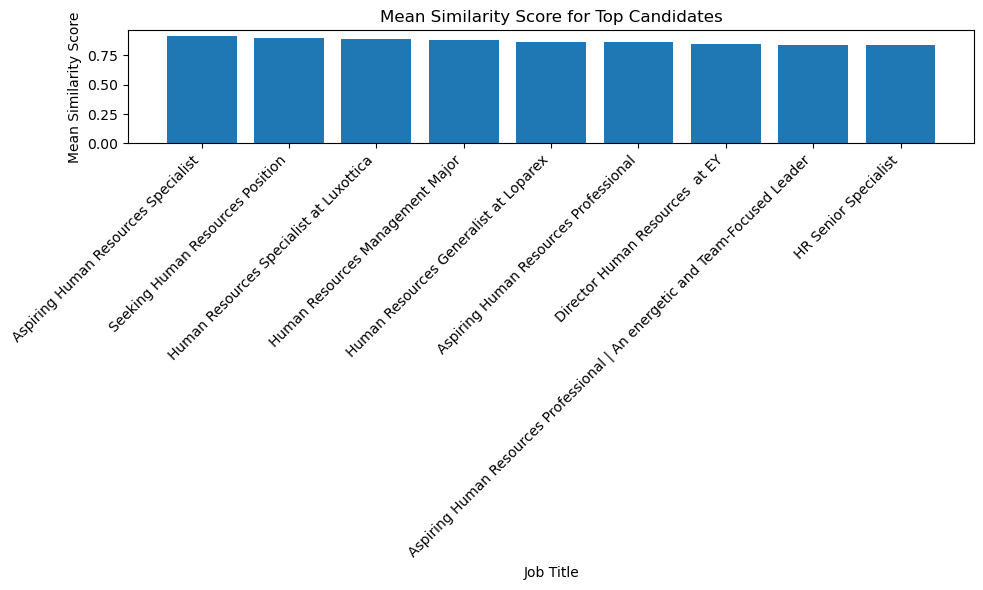

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(final_rank['job_title'], final_rank['mean_similarity'])
plt.xlabel('Job Title')
plt.ylabel('Mean Similarity Score')
plt.title('Mean Similarity Score for Top Candidates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
